# Telecom Customer Churn

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import skew, kurtosis
from imblearn.over_sampling import SMOTE

import mlflow
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from statsmodels.api import Logit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pickle

from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings

warnings.filterwarnings("ignore")
start_time = datetime.now()

In [122]:
ROOT_PATH = Path(__name__).resolve().parent.parent

FILE_NAME = "TelecomCustomerChurn.csv"

FILE_PATH = os.path.join(ROOT_PATH, "data",FILE_NAME)

In [123]:
df = pd.read_csv(FILE_PATH)
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Monthly,Yes,Manual,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Manual,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,70.70,151.65,Yes


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [125]:
df.isnull().sum()

customerID          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [126]:
df["TotalCharges"] = df["TotalCharges"].apply(
    lambda x: None if x == " " else float(x)
)

In [127]:
df.isnull().sum()

customerID           0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [128]:
amount_of_nulls = df["TotalCharges"].isna().sum()
amount_of_data = len(df)

print(f"{(amount_of_nulls / amount_of_data) * 100} %")

0.1561834445548772 %


Since this amount of NaN values represents only 0.15% of the data, we can take it out because it won't make a big impact on our analysis

In [129]:
df = df.loc[~df["TotalCharges"].isna()]

#### Evaluating the Gender acitivity

In [131]:
df_gender_churn = df.groupby(
    ["Gender", "Churn"]
    ).agg({"Churn":"count"}).rename(
        columns={"Churn": "churn_count"}
    ).reset_index()

df_gender_churn = df_gender_churn.pivot_table(
    index="Gender", values="churn_count", columns="Churn"
)

df_gender_churn

Churn,No,Yes
Gender,,
Female,2544.0,939.0
Male,2619.0,930.0


Just evalue if there is a statistical relevance on Male and Female churns

Applying a Statistical teste called: Chi-Squared 

In [132]:
def statistical_chisquared(p_value: float):
    if p_value <= 0.05:
        print(f"There is a relevant difference between these genres. \np_value: {p_value}")
    else:
        print(f"There is no relevant difference between these genres. \np_value: {p_value}")

In [133]:
chi2, p, dof, expected = chi2_contingency(df_gender_churn)
statistical_chisquared(p)

There is no relevant difference between these genres. 
p_value: 0.490488470706551


In [134]:
df["Gender"].value_counts()

Gender
Male      3549
Female    3483
Name: count, dtype: int64

In [135]:
df.groupby(
    ["Gender"]
    ).agg({"TotalCharges":"sum"}).rename(
        columns={"TotalCharges": "TotalCharges_sum"}
    ).reset_index()

,Gender,TotalCharges_sum
0,Female,7952354.2
1,Male,8103814.5


#### Evaluating type of service

In [136]:
df["InternetService"].value_counts()

InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64

In [137]:
df_internet_service = df.groupby(
    ["InternetService", "Churn"]
    ).agg({"Churn":"count"}).rename(
        columns={"Churn": "churn_count"}
    ).reset_index()

df_internet_service = df_internet_service.pivot_table(
    index="InternetService", values="churn_count", columns="Churn"
)

df_internet_service["total"] = df_internet_service["No"] + df_internet_service["Yes"]

df_internet_service["churn_percent_service_categ"] = (df_internet_service["Yes"] / df_internet_service["total"]) * 100
df_internet_service["churn_percent_global"] = (df_internet_service["total"] / df_internet_service["total"].sum()) * 100

df_internet_service

Churn,No,Yes,total,churn_percent_service_categ,churn_percent_global
InternetService,,,,,
DSL,1957.0,459.0,2416.0,18.998344,34.357224
Fiber optic,1799.0,1297.0,3096.0,41.892765,44.027304
No,1407.0,113.0,1520.0,7.434211,21.615472


The Fiber Optic Internet represents 44% of the customer. However it is clear that the amount of customer in Fiber Optic 41% are cancelling our sevices. Proportionally it makes sense because the are the biggest amount of customers, although our services are not supplying the customer expecations of more than 40% of our client databases.

Based on bussiness areas needs I could proceed with the some more Ad Hoc Analysis. Although I'll move forward to the modeling structure

In [139]:
df_dummy = pd.get_dummies(data=df.drop(["customerID", "Churn"], axis=1), dtype=int)
df_dummy.head()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Gender_Female,Gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_No,StreamingMovies_Yes,Contract_Monthly,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Manual
0,0,1,29.85,29.85,1,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,1
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,1,0,0,1,0,1,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,...,1,0,1,0,0,0,1,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,1,0,0,1,0,1,0,1,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,1,0,1,0,0,0,1,0,0,1


In [140]:
df_dummy.describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Gender_Female,Gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_No,StreamingMovies_Yes,Contract_Monthly,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Manual
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.495307,0.504693,0.517491,0.482509,0.701507,0.298493,...,0.611633,0.388367,0.551052,0.209329,0.239619,0.407281,0.592719,0.219283,0.216297,0.564420
std,0.368844,24.545260,30.085974,2266.771362,0.500014,0.500014,0.499729,0.499729,0.457629,0.457629,...,0.487414,0.487414,0.497422,0.406858,0.426881,0.491363,0.491363,0.413790,0.411748,0.495868
min,0.000000,1.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


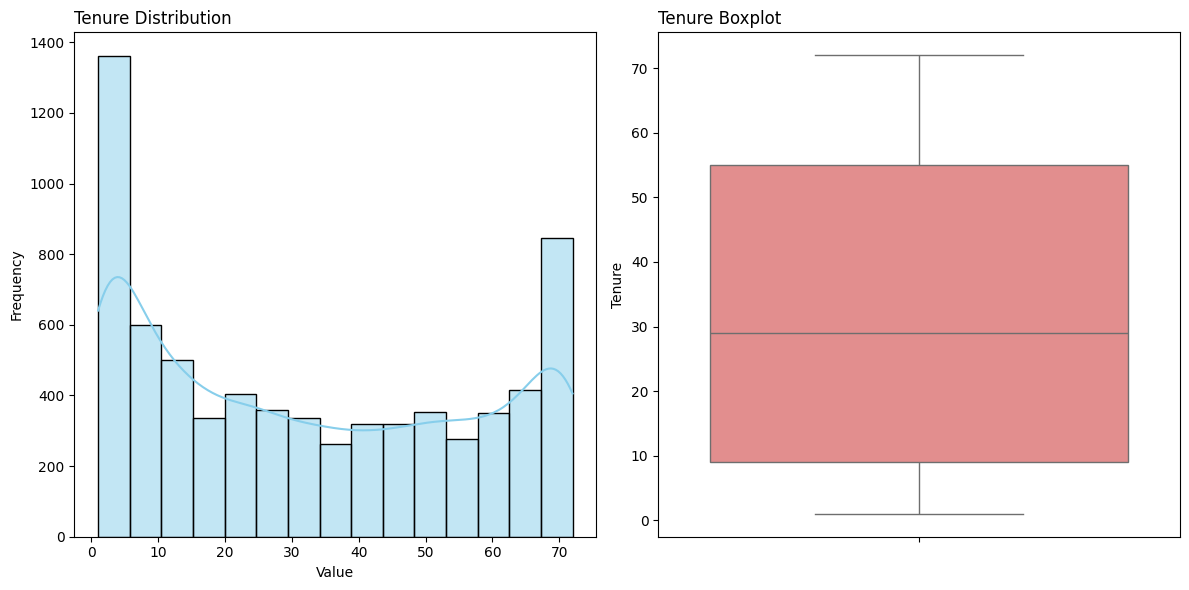

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df_dummy, x="Tenure", kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Tenure Distribution", loc="left")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

sns.boxplot(data=df_dummy, y="Tenure", ax=axes[1], color="lightcoral")
axes[1].set_title("Tenure Boxplot", loc="left")

plt.tight_layout()
plt.show();

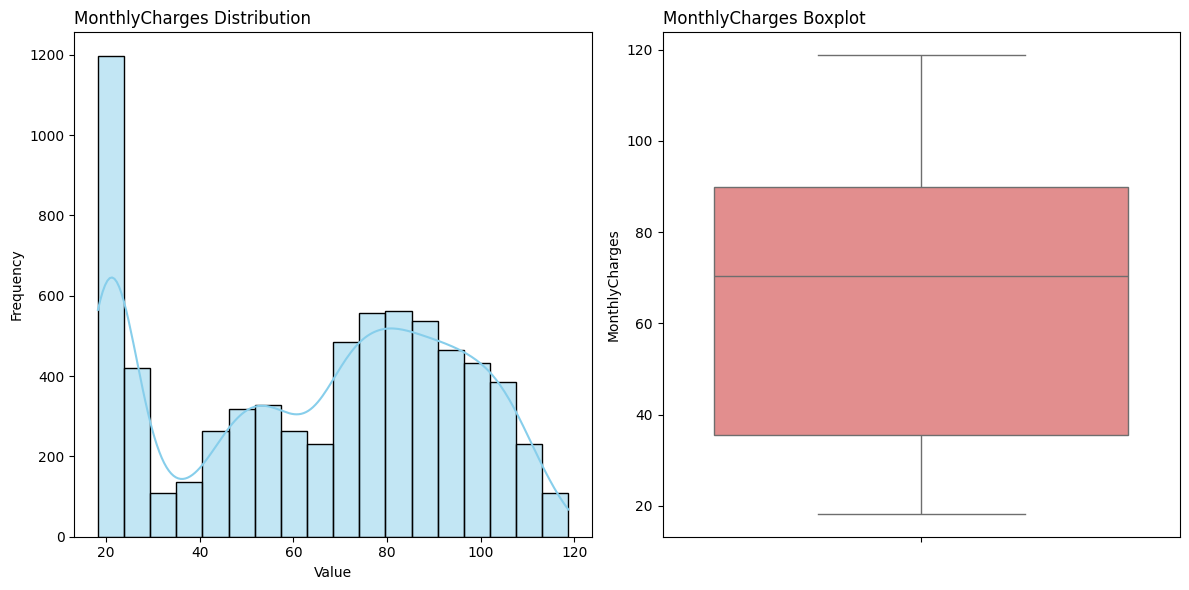

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df_dummy, x="MonthlyCharges", kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("MonthlyCharges Distribution", loc="left")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

sns.boxplot(data=df_dummy, y="MonthlyCharges", ax=axes[1], color="lightcoral")
axes[1].set_title("MonthlyCharges Boxplot", loc="left")

plt.tight_layout()
plt.show();

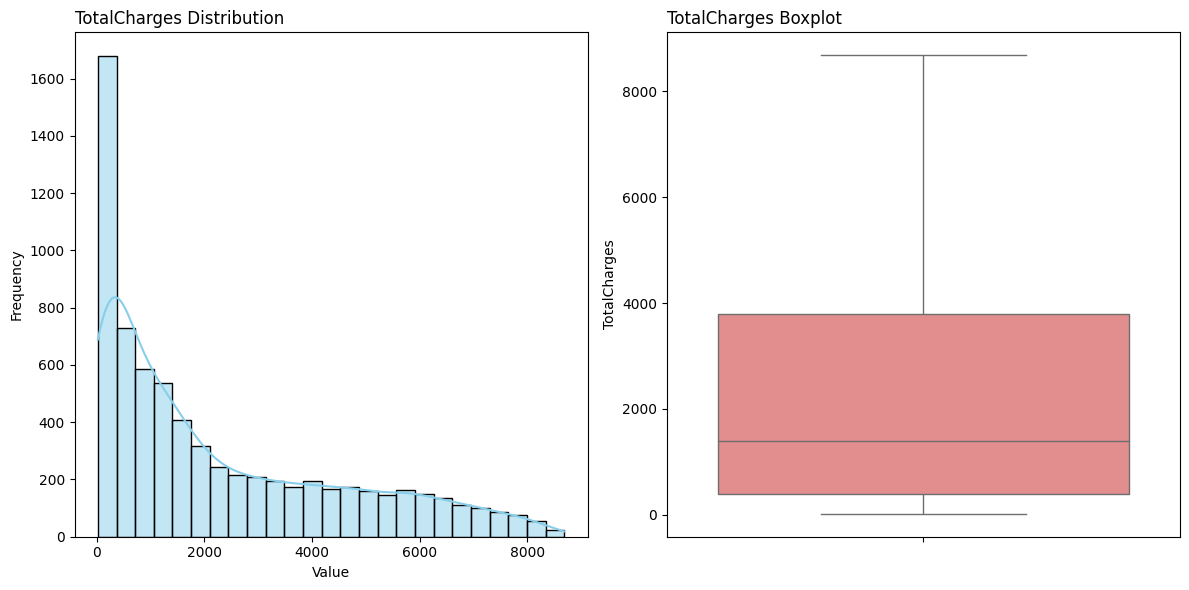

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df_dummy, x="TotalCharges", kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("TotalCharges Distribution", loc="left")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

sns.boxplot(data=df_dummy, y="TotalCharges", ax=axes[1], color="lightcoral")
axes[1].set_title("TotalCharges Boxplot", loc="left")

plt.tight_layout()
plt.show();

In [144]:
df_dummy_temp = pd.get_dummies(data=df.drop(["customerID", "Churn"], axis=1), dtype=int, drop_first=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = df_dummy_temp.columns
vif_data["VIF"] = [variance_inflation_factor(df_dummy_temp.values, i) for i in range(df_dummy_temp.shape[1])]

vif_data

,Feature,VIF
0,SeniorCitizen,1.372809
1,Tenure,19.961285
2,MonthlyCharges,211.407548
3,TotalCharges,20.975890
4,Gender_Male,2.021273
5,Partner_Yes,2.822596
6,Dependents_Yes,1.967383
7,PhoneService_Yes,47.183952
8,MultipleLines_Yes,2.843424
9,InternetService_Fiber optic,17.342421


Variables with high level of multicolinearity. I'll try dropping some variables with high values to evaluate if the VIF reduces

In [145]:
test_cols_drop = ["customerID", "Churn", "MonthlyCharges", "Tenure"]
df_dummy_temp = pd.get_dummies(data=df.drop(test_cols_drop, axis=1), dtype=int, drop_first=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = df_dummy_temp.columns
vif_data["VIF"] = [variance_inflation_factor(df_dummy_temp.values, i) for i in range(df_dummy_temp.shape[1])]

vif_data

,Feature,VIF
0,SeniorCitizen,1.352379
1,TotalCharges,7.948890
2,Gender_Male,1.923930
3,Partner_Yes,2.747944
4,Dependents_Yes,1.959154
5,PhoneService_Yes,9.229601
6,MultipleLines_Yes,2.504991
7,InternetService_Fiber optic,3.858821
8,InternetService_No,3.173177
9,OnlineSecurity_Yes,1.980164


There was a good reduction of VIF on the remaining variables. Let's proceed with these to the model

Checking data Balancing

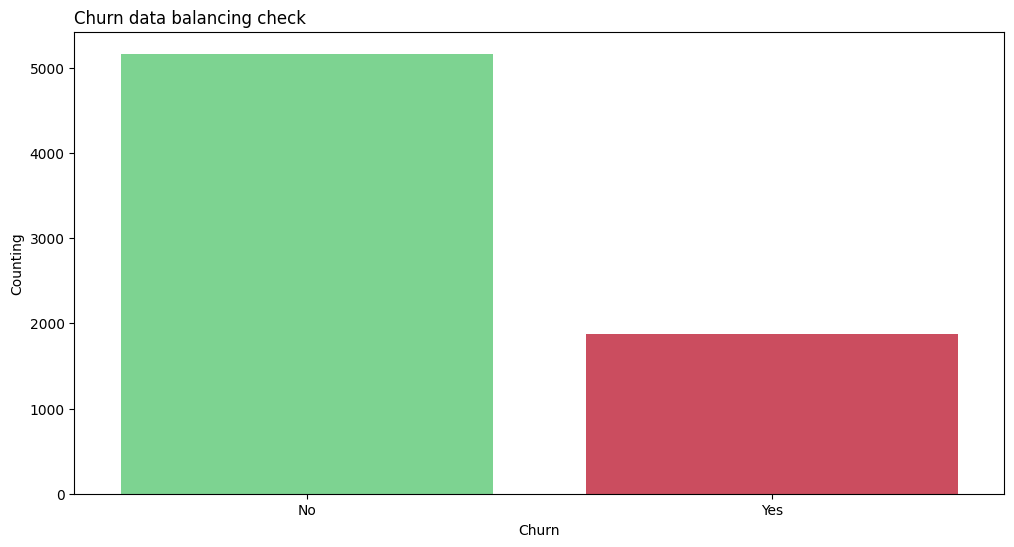

In [146]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="Churn", hue="Churn", palette={"Yes": "#E03850", "No": "#6FE189"})
plt.title("Churn data balancing check", loc="left")
plt.ylabel("Counting")
plt.show();

In [147]:
balance_analysis = pd.DataFrame(
    [df["Churn"].value_counts().to_dict()]
).T.rename(columns={0: "count"})

balance_analysis["percent"] = (balance_analysis["count"] / balance_analysis["count"].sum()) * 100
balance_analysis

,count,percent
No,5163,73.421502
Yes,1869,26.578498


In [148]:
df["Churn"] = df["Churn"].apply(
    lambda x: 1 if x=="Yes" else 0
)

In [149]:
sampler = SMOTE()
data_smote = sampler.fit_resample(df_dummy, df["Churn"])

X_smote = data_smote[0]
y_smote = data_smote[1]

Separate data into X, y, Train and Test

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2)

print("Independent DF for Training:", X_train.shape)
print("Independent DF for Testing:", X_test.shape)
print("\nDependent DF for Training:", y_train.shape)
print("Dependent DF for Testing:", y_test.shape)

Independent DF for Training: (8260, 37)
Independent DF for Testing: (2066, 37)

Dependent DF for Training: (8260,)
Dependent DF for Testing: (2066,)


In [151]:
def compute_statistics(series: pd.Series):
    data = np.array(series).astype(float)
    
    stats = {
        "mean": np.mean(data),
        "median": np.median(data),
        "std": np.std(data, ddof=1),
        "skewness": skew(data, bias=False),
        "kurtosis": kurtosis(data, bias=False)
    }

    return stats

In [152]:
def get_variable_dist(df: pd.DataFrame):
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("Data Drift Monitor")

    for col in df.columns:
        with mlflow.start_run(run_name=f"drift_{datetime.today()}"):
            ## Creating IMAGE
            img_path = f"../data/image/{col}.png"

            _, axes = plt.subplots(1, 2, figsize=(12, 6))
            sns.histplot(data=df, x=f"{col}", kde=True, ax=axes[0], color="skyblue")
            axes[0].set_title(f"{col} Distribution", loc="left")
            axes[0].set_xlabel("Value")
            axes[0].set_ylabel("Frequency")

            sns.boxplot(data=df, y=f"{col}", ax=axes[1], color="lightcoral")
            axes[1].set_title(f"{col} Boxplot", loc="left")

            plt.savefig(img_path)
            plt.close()

            ## Creating Statistics
            stats = compute_statistics(df[col])

            mlflow.set_tag(key="table_column", value=col)
            mlflow.log_artifact(img_path, artifact_path=f"plots")
            mlflow.log_metric(key="mean", value=stats["mean"])
            mlflow.log_metric(key="median", value=stats["median"])
            mlflow.log_metric(key="std", value=stats["std"])
            mlflow.log_metric(key="skewness", value=stats["skewness"])
            mlflow.log_metric(key="kurtosis", value=stats["kurtosis"])

In [153]:
get_variable_dist(df_dummy)

🏃 View run drift_2025-10-31 21:21:18.938390 at: http://localhost:5000/#/experiments/540392006916120203/runs/54c409a30d9141abb974dadf169560e1
🧪 View experiment at: http://localhost:5000/#/experiments/540392006916120203
🏃 View run drift_2025-10-31 21:21:19.375187 at: http://localhost:5000/#/experiments/540392006916120203/runs/26a5ac7e347b43298bb1aae7f6fd20fa
🧪 View experiment at: http://localhost:5000/#/experiments/540392006916120203
🏃 View run drift_2025-10-31 21:21:19.765106 at: http://localhost:5000/#/experiments/540392006916120203/runs/f36222f79ef54592aa186e08ea2d540f
🧪 View experiment at: http://localhost:5000/#/experiments/540392006916120203
🏃 View run drift_2025-10-31 21:21:20.162620 at: http://localhost:5000/#/experiments/540392006916120203/runs/022bfde4477f4abfb786797b75eeb42d
🧪 View experiment at: http://localhost:5000/#/experiments/540392006916120203
🏃 View run drift_2025-10-31 21:21:20.591779 at: http://localhost:5000/#/experiments/540392006916120203/runs/b478f5411f7b4e349e5b

## Model

Measuring model performance:<br>

But, which metrics should I use?<br>

Erro Tipo I (α) — Falso Positivo
Ocorre quando o modelo detecta algo que não existe.

Em termos estatísticos: rejeita a hipótese nula quando ela é verdadeira.

Na matriz: corresponde ao FP (False Positive).

In [154]:
def quantify_model_prediction(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    return precision, conf_matrix

In [155]:
def save_model_on_blob(model, model_name):
    blob_path = "../models/"

    # model_name = type(model).__name__

    deep_learning_models = ["Sequential"]
    if model_name in deep_learning_models:
        model_file = f"{model_name}_{datetime.today().strftime("%Y%m%d_%H%M%S")}.keras"
        model_path = os.path.join(blob_path, model_file)

        model.save(model_path)
        print("Deep Learning model saved successfully.")
    else:
        model_file = f"{model_name}_{datetime.today().strftime("%Y%m%d_%H%M%S")}.pkl"
        model_path = os.path.join(blob_path, model_file)

        with open(model_path, "wb") as f:
            pickle.dump(obj=model, file=f)
        print("Machine Learning model saved successfully.")

    return model_path

In [156]:
def register_model_on_model_registry(model_name):
    run = mlflow.active_run()
    model_uri = f"runs:/{run.info.run_id}/model"

    registered_model = mlflow.register_model(
        model_uri=model_uri,
        name=model_name
    )

    print("Registered Model:", registered_model.name)

In [157]:
def register_model_experiment(model_name: str, y_true, y_pred, type: str, model_object): # Aqui não é um path, aqui deve ser um objeto modelo. Alterar depois
    deep_learning_models = ["Sequential"]
    recall, _ = quantify_model_prediction(y_true, y_pred)

    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("Churn Model Experiment")

    with mlflow.start_run(run_name=f"{model_name}_{datetime.today()}"):
        mlflow.log_metric(key="precision", value=recall)
        mlflow.set_tag(key="Type", value=type)

        if model_name in deep_learning_models:
            try:
                mlflow.keras.log_model(model=model_object, artifact_path="model", registered_model_name=model_name)
            except:
                pass
        else:
            try:
                mlflow.sklearn.log_model(sk_model=model_object, artifact_path="model", registered_model_name=model_name)
            except:
                pass

        if type == "Test":
            register_model_on_model_registry(model_name)

### Modeling

In [158]:
base_model = Logit(y_train, X_train) # Using the standard parameters
base_model = base_model.fit()

base_model_response = base_model.predict(X_train)

Optimization terminated successfully.
         Current function value: 0.316590
         Iterations 10


In [159]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 8260
Model:                          Logit   Df Residuals:                     8223
Method:                           MLE   Df Model:                           36
Date:                Fri, 31 Oct 2025   Pseudo R-squ.:                  0.5432
Time:                        21:21:34   Log-Likelihood:                -2615.0
converged:                       True   LL-Null:                       -5725.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
SeniorCitizen                               0.0556      0.095      0.588      0.557      -0.130       0.241
Tenure                                     -0.0685      0.006    -10.545      0.000      -0.081      -0.056
MonthlyCharges                              0.3397      0.020     17.361      0.000       0.301       0.378
TotalCharges                                0.0004   7.37e-05      5.935      0.000       0.000       0.001
Gender_Female                              -2.4235      0.382     -6.337      0.000      -3.173      -1.674
Gender_Male                                -2.4383      0.382     -6.379      0.000      -3.187      -1.689
Partner_No                                 -1.8546      0.421     -4.405      0.000      -2.680      -1.029
Partner_Yes                                -1.8857      0.424     -4.449      0.000      -2.716      -1.055
Dependents_No                              -1.5873      0.426     -3.730      0.000      -2.421      -0.753
Dependents_Yes                             -1.8739      0.432     -4.333      0.000      -2.721      -1.026
PhoneService_No                             2.9646      0.920      3.221      0.001       1.161       4.769
PhoneService_Yes                           -4.6850      0.898     -5.215      0.000      -6.446      -2.924
MultipleLines_No                           -0.5564      0.412     -1.350      0.177      -1.364       0.251
MultipleLines_Yes                          -2.0927      0.420     -4.978      0.000      -2.917      -1.269
InternetService_DSL                        -1.9160      1.022     -1.875      0.061      -3.918       0.086
InternetService_Fiber optic                -9.5290      1.295     -7.358      0.000     -12.067      -6.991
InternetService_No                          6.0983      0.948      6.432      0.000       4.240       7.956
OnlineSecurity_No                          -0.0381      0.455     -0.084      0.933      -0.931       0.855
OnlineSecurity_Yes                         -2.3555      0.483     -4.881      0.000      -3.301      -1.410
OnlineBackup_No                            -0.2711      0.418     -0.649      0.516      -1.090       0.547
OnlineBackup_Yes                           -2.1758      0.435     -5.005      0.000      -3.028      -1.324
DeviceProtection_No                        -0.4840      0.421     -1.149      0.251      -1.310       0.342
DeviceProtection_Yes                       -2.2908      0.442     -5.186      0.000      -3.157      -1.425
TechSupport_No                              0.4284      0.446      0.961      0.337      -0.445       1.302
TechSupport_Yes                            -1.7894      0.463     -3.867      0.000      -2.696      -0.883
StreamingTV_No                              1.2768      0.444      2.874      0.004       0.406       2.147
StreamingTV_Yes                            -2.0107      0.466     -4.318      0.000      -2.923      -1.098
S

In [160]:
cols_to_drop = [
    "SeniorCitizen",
    "MultipleLines_No",
    "InternetService_DSL",
    "OnlineSecurity_No",
    "OnlineBackup_No",
    "DeviceProtection_No",
    "TechSupport_No",
    "StreamingMovies_No",
    "Contract_Monthly"
]

base_model = Logit(y_train, X_train.drop(cols_to_drop, axis=1)) # Using the standard parameters
base_model = base_model.fit()

base_model_response = base_model.predict(X_train.drop(cols_to_drop, axis=1))

base_model.summary()

Optimization terminated successfully.
         Current function value: 0.317681
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 8260
Model:                          Logit   Df Residuals:                     8232
Method:                           MLE   Df Model:                           27
Date:                Fri, 31 Oct 2025   Pseudo R-squ.:                  0.5417
Time:                        21:21:34   Log-Likelihood:                -2624.0
converged:                       True   LL-Null:                       -5725.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Tenure                                     -0.0684      0.006    -10.560      0.000      -0.081      -0.056
MonthlyCharges                              0.3343      0.019     17.412      0.000       0.297       0.372
TotalCharges                                0.0004   7.36e-05      5.987      0.000       0.000       0.001
Gender_Female                              -2.3085      0.359     -6.428      0.000      -3.012      -1.605
Gender_Male                                -2.3240      0.359     -6.475      0.000      -3.027      -1.621
Partner_No                                 -1.9317      0.404     -4.782      0.000      -2.723      -1.140
Partner_Yes                                -1.9639      0.407     -4.828      0.000      -2.761      -1.167
Dependents_No                              -1.4950      0.400     -3.735      0.000      -2.280      -0.710
Dependents_Yes                             -1.7910      0.408     -4.388      0.000      -2.591      -0.991
PhoneService_No                             1.3954      0.512      2.723      0.006       0.391       2.400
PhoneService_Yes                           -6.1268      0.720     -8.506      0.000      -7.539      -4.715
MultipleLines_Yes                          -1.5282      0.126    -12.123      0.000      -1.775      -1.281
InternetService_Fiber optic                -7.4749      0.487    -15.356      0.000      -8.429      -6.521
InternetService_No                          7.8600      0.503     15.639      0.000       6.875       8.845
OnlineSecurity_Yes                         -2.3022      0.133    -17.287      0.000      -2.563      -2.041
OnlineBackup_Yes                           -1.8832      0.127    -14.860      0.000      -2.132      -1.635
DeviceProtection_Yes                       -1.7954      0.129    -13.875      0.000      -2.049      -1.542
TechSupport_Yes                            -2.1874      0.136    -16.100      0.000      -2.454      -1.921
StreamingTV_No                              1.4643      0.378      3.872      0.000       0.723       2.206
StreamingTV_Yes                            -1.7828      0.408     -4.373      0.000      -2.582      -0.984
StreamingMovies_Yes                        -3.1519      0.210    -14.975      0.000      -3.564      -2.739
Contract_One year                          -0.7986      0.119     -6.707      0.000      -1.032      -0.565
Contract_Two year                          -1.4359      0.191     -7.502      0.000      -1.811      -1.061
PaperlessBilling_No                        -2.2542      0.393     -5.734      0.000      -3.025      -1.484
PaperlessBilling_Yes                       -1.7996      0.392     -4.594      0.000      -2.567      -1.032
PaymentMethod_Bank transfer (automatic)    -2.7515      0.410     -6.719      0.000      -3.554      -1.949
PaymentMethod_Credit card (automatic)      -2.8699      0.411     -6.982      0.000      -3.676      -2.064
P

In [161]:
model_params = {
    "LogisticRegression":{
        "penalty":["l1", "l2", "elasticnet", None],
        "dual": [True, False],
        "tol": [1e-4, 0.001, 0.01],
    }, 
    "RandomForestClassifier":{
        "n_estimators": [10, 100, 1000],
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [10, 100, 1000],
        # "min_samples_split": [1, 2],
        # "min_samples_leaf": [1, 2],
        # "max_features": ["sqrt", "log2", None],
    }, 
    "DecisionTreeClassifier":{
        "splitter": ["best", "random"],
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [10, 100, 1000],
        # "min_samples_split": [1, 2],
        # "min_samples_leaf": [1, 2],
        # "max_features": ["sqrt", "log2", None],
    }, 
    "SVC":{
        "C": [1.0, 2.0, 3.0],
        # "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed"],
        "degree": [3, 6 ,9],
        # "probability": [True, False],
    }, 
    "XGBClassifier":{
        "n_estimators": [1, 5, 15, 30, 60],
        "max_depth": [10, 100, 1000],
        # "max_leaves": [10, 100, 1000],
        # "learning_rate": [1e-4, 0.001, 0.01],
    }, 
}

In [162]:
models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "SVC": SVC(),
    "XGBClassifier": XGBClassifier(), 
}

In [186]:
len(X_train.columns)

37

Training with all columns

In [163]:
for model_name in model_params:
    estimator = models[model_name]
    param_grid = model_params[model_name]

    start_training_time = datetime.now()
    print(f"\n\n>>>>>>> Training {model_name} <<<<<<")

    grid_cv = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=2
    )

    grid_cv.fit(X_train, y_train)
    # model_path = save_model_on_blob(grid_cv, model_name)

    result_prediction_train = grid_cv.predict(X_train)
    register_model_experiment(model_name, y_train, result_prediction_train, "Train", None)
    
    result_prediction_test = grid_cv.predict(X_test)
    register_model_experiment(model_name, y_test, result_prediction_test, "Test", grid_cv)
    end_training_time = datetime.now()


    training_time = end_training_time - start_training_time

    print(f">>>>>>> Finishing Training of model {model_name} in {training_time} <<<<<<")



>>>>>>> Training LogisticRegression <<<<<<


2025/10/31 21:21:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/31 21:21:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2025/10/31 21:21:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 15
Created version '15' of model 'LogisticRegression'.


🏃 View run LogisticRegression_2025-10-31 21:21:35.453674 at: http://localhost:5000/#/experiments/488898870833171410/runs/879d72c1922e4fe68050e203df969cff
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


2025/10/31 21:21:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2025/10/31 21:21:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 16
Created version '16' of model 'LogisticRegression'.
Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2025/10/31 21:21:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 17
Created version '17' of model 'LogisticRegression'.


Registered Model: LogisticRegression
🏃 View run LogisticRegression_2025-10-31 21:21:38.446785 at: http://localhost:5000/#/experiments/488898870833171410/runs/021682fde017487b8026420d35adf268
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410
>>>>>>> Finishing Training of model LogisticRegression in 0:00:07.803375 <<<<<<


>>>>>>> Training RandomForestClassifier <<<<<<


2025/10/31 21:22:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/31 21:23:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2025/10/31 21:23:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 13
Created version '13' of model 'RandomForestClassifier'.


🏃 View run RandomForestClassifier_2025-10-31 21:22:57.481502 at: http://localhost:5000/#/experiments/488898870833171410/runs/e9ff2474f00a4fd7af6ca1fdef3fb762
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


2025/10/31 21:23:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2025/10/31 21:23:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 14
Created version '14' of model 'RandomForestClassifier'.
Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2025/10/31 21:23:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 15
Created version '15' of model 'RandomForestClassifier'.


Registered Model: RandomForestClassifier
🏃 View run RandomForestClassifier_2025-10-31 21:23:00.487400 at: http://localhost:5000/#/experiments/488898870833171410/runs/e4f3db7406474dada6daadaca4481dd0
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410
>>>>>>> Finishing Training of model RandomForestClassifier in 0:01:21.796382 <<<<<<


>>>>>>> Training DecisionTreeClassifier <<<<<<


2025/10/31 21:23:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/31 21:23:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DecisionTreeClassifier' already exists. Creating a new version of this model...
2025/10/31 21:23:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier, version 13
Created version '13' of model 'DecisionTreeClassifier'.


🏃 View run DecisionTreeClassifier_2025-10-31 21:23:05.038849 at: http://localhost:5000/#/experiments/488898870833171410/runs/63be25d828714164a062a62ffeeb80b2
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


2025/10/31 21:23:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DecisionTreeClassifier' already exists. Creating a new version of this model...
2025/10/31 21:23:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier, version 14
Created version '14' of model 'DecisionTreeClassifier'.
Registered model 'DecisionTreeClassifier' already exists. Creating a new version of this model...
2025/10/31 21:23:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier, version 15
Created version '15' of model 'DecisionTreeClassifier'.


Registered Model: DecisionTreeClassifier
🏃 View run DecisionTreeClassifier_2025-10-31 21:23:07.830062 at: http://localhost:5000/#/experiments/488898870833171410/runs/59b87940f5e4471dbbc4905c11cd9577
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410
>>>>>>> Finishing Training of model DecisionTreeClassifier in 0:00:06.940616 <<<<<<


>>>>>>> Training SVC <<<<<<


2025/10/31 21:23:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/31 21:23:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SVC' already exists. Creating a new version of this model...
2025/10/31 21:23:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC, version 13
Created version '13' of model 'SVC'.


🏃 View run SVC_2025-10-31 21:23:33.555908 at: http://localhost:5000/#/experiments/488898870833171410/runs/0b909ff1dbdb4c74a59c933851c7796d
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


2025/10/31 21:23:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SVC' already exists. Creating a new version of this model...
2025/10/31 21:23:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC, version 14
Created version '14' of model 'SVC'.
Registered model 'SVC' already exists. Creating a new version of this model...
2025/10/31 21:23:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC, version 15
Created version '15' of model 'SVC'.


Registered Model: SVC
🏃 View run SVC_2025-10-31 21:23:37.005137 at: http://localhost:5000/#/experiments/488898870833171410/runs/64c8699a4ed84bbdb2e5794a6c369497
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410
>>>>>>> Finishing Training of model SVC in 0:00:29.204652 <<<<<<


>>>>>>> Training XGBClassifier <<<<<<


2025/10/31 21:23:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/31 21:23:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2025/10/31 21:23:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 13
Created version '13' of model 'XGBClassifier'.


🏃 View run XGBClassifier_2025-10-31 21:23:42.505649 at: http://localhost:5000/#/experiments/488898870833171410/runs/01f5cc4a15d84252b66265b81fec4ff7
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


2025/10/31 21:23:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2025/10/31 21:23:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 14
Created version '14' of model 'XGBClassifier'.
Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2025/10/31 21:23:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 15


Registered Model: XGBClassifier
🏃 View run XGBClassifier_2025-10-31 21:23:45.345107 at: http://localhost:5000/#/experiments/488898870833171410/runs/844491d357b14a69ad52d2aba67a4026
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410
>>>>>>> Finishing Training of model XGBClassifier in 0:00:08.633724 <<<<<<


Created version '15' of model 'XGBClassifier'.


Training without columns with p-value >= 0.05

In [164]:
cols_to_drop = [
    "SeniorCitizen",
    "MultipleLines_No",
    "InternetService_DSL",
    "OnlineSecurity_No",
    "OnlineBackup_No",
    "DeviceProtection_No",
    "TechSupport_No",
    "StreamingMovies_No",
    "Contract_Monthly"
]

In [165]:
for model_name in model_params:
    estimator = models[model_name]
    param_grid = model_params[model_name]

    start_training_time = datetime.now()
    print(f"\n>>>>>>> Training {model_name} <<<<<<")

    grid_cv = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=2
    )

    grid_cv.fit(X_train.drop(cols_to_drop, axis=1), y_train)
    # model_path = save_model_on_blob(grid_cv, model_name)

    result_prediction_train = grid_cv.predict(X_train.drop(cols_to_drop, axis=1))
    register_model_experiment(model_name, y_train, result_prediction_train, "Train", None)
    
    result_prediction_test = grid_cv.predict(X_test.drop(cols_to_drop, axis=1))
    register_model_experiment(model_name, y_test, result_prediction_test, "Test", grid_cv)
    end_training_time = datetime.now()

    training_time = end_training_time - start_training_time

    print(f">>>>>>> Finishing Training of model {model_name} in {training_time} <<<<<<")


>>>>>>> Training LogisticRegression <<<<<<


2025/10/31 21:23:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/31 21:23:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2025/10/31 21:23:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 18
Created version '18' of model 'LogisticRegression'.


🏃 View run LogisticRegression_2025-10-31 21:23:49.865276 at: http://localhost:5000/#/experiments/488898870833171410/runs/5c1cce1965a442d3ab8dc37f22b13f64
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


2025/10/31 21:23:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2025/10/31 21:23:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 19
Created version '19' of model 'LogisticRegression'.
Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2025/10/31 21:23:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 20
Created version '20' of model 'LogisticRegression'.


Registered Model: LogisticRegression
🏃 View run LogisticRegression_2025-10-31 21:23:52.762220 at: http://localhost:5000/#/experiments/488898870833171410/runs/4a0127f6f3ad4800ae8407b70db20a7a
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410
>>>>>>> Finishing Training of model LogisticRegression in 0:00:07.193316 <<<<<<

>>>>>>> Training RandomForestClassifier <<<<<<


2025/10/31 21:25:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/31 21:25:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2025/10/31 21:25:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 16
Created version '16' of model 'RandomForestClassifier'.


🏃 View run RandomForestClassifier_2025-10-31 21:25:15.363393 at: http://localhost:5000/#/experiments/488898870833171410/runs/f3e281a0d5ee42f499c2162e748e9cd0
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


2025/10/31 21:25:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2025/10/31 21:25:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 17
Created version '17' of model 'RandomForestClassifier'.
Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2025/10/31 21:25:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 18
Created version '18' of model 'RandomForestClassifier'.


Registered Model: RandomForestClassifier
🏃 View run RandomForestClassifier_2025-10-31 21:25:18.609855 at: http://localhost:5000/#/experiments/488898870833171410/runs/3721dfdd48094de38d0b89cdae35fa63
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410
>>>>>>> Finishing Training of model RandomForestClassifier in 0:01:29.009433 <<<<<<

>>>>>>> Training DecisionTreeClassifier <<<<<<


2025/10/31 21:25:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/31 21:25:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DecisionTreeClassifier' already exists. Creating a new version of this model...
2025/10/31 21:25:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier, version 16
Created version '16' of model 'DecisionTreeClassifier'.


🏃 View run DecisionTreeClassifier_2025-10-31 21:25:25.923696 at: http://localhost:5000/#/experiments/488898870833171410/runs/4a9afe804ca3428182748b00b95bcdc2
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


2025/10/31 21:25:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DecisionTreeClassifier' already exists. Creating a new version of this model...
2025/10/31 21:25:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier, version 17
Created version '17' of model 'DecisionTreeClassifier'.
Registered model 'DecisionTreeClassifier' already exists. Creating a new version of this model...
2025/10/31 21:25:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier, version 18
Created version '18' of model 'DecisionTreeClassifier'.


Registered Model: DecisionTreeClassifier
🏃 View run DecisionTreeClassifier_2025-10-31 21:25:28.698608 at: http://localhost:5000/#/experiments/488898870833171410/runs/f722bd9f130f40dc93848fc8f8be205b
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410
>>>>>>> Finishing Training of model DecisionTreeClassifier in 0:00:06.798712 <<<<<<

>>>>>>> Training SVC <<<<<<


2025/10/31 21:25:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/31 21:25:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SVC' already exists. Creating a new version of this model...
2025/10/31 21:25:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC, version 16
Created version '16' of model 'SVC'.


🏃 View run SVC_2025-10-31 21:25:54.949398 at: http://localhost:5000/#/experiments/488898870833171410/runs/0d2c9aaa0545465a83292d1d0653295e
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


2025/10/31 21:26:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'SVC' already exists. Creating a new version of this model...
2025/10/31 21:26:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC, version 17
Created version '17' of model 'SVC'.
Registered model 'SVC' already exists. Creating a new version of this model...
2025/10/31 21:26:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC, version 18
Created version '18' of model 'SVC'.


Registered Model: SVC
🏃 View run SVC_2025-10-31 21:25:58.667226 at: http://localhost:5000/#/experiments/488898870833171410/runs/cf59c49d38464a3d87d40a3413a6547c
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410
>>>>>>> Finishing Training of model SVC in 0:00:30.253115 <<<<<<

>>>>>>> Training XGBClassifier <<<<<<


2025/10/31 21:26:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/31 21:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2025/10/31 21:26:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 16
Created version '16' of model 'XGBClassifier'.


🏃 View run XGBClassifier_2025-10-31 21:26:04.538412 at: http://localhost:5000/#/experiments/488898870833171410/runs/38401692870e474ba2c3120255b4e37d
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


2025/10/31 21:26:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2025/10/31 21:26:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 17
Created version '17' of model 'XGBClassifier'.
Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2025/10/31 21:26:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 18


Registered Model: XGBClassifier
🏃 View run XGBClassifier_2025-10-31 21:26:07.707344 at: http://localhost:5000/#/experiments/488898870833171410/runs/569b5f3d48e64614945393c1028bcdd7
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410
>>>>>>> Finishing Training of model XGBClassifier in 0:00:09.286448 <<<<<<


Created version '18' of model 'XGBClassifier'.


Reducing the amount of avariables, we've got a small performance improvement during training phase for most of the models. However it does not impact on test that much. Even if it does have such impact, the training was faster. So we can proceed with with this second structure: 'Dropping unecessary columns (Statisticaly non relevant columns)'

In [167]:
model_keras_v1 = keras.Sequential([
    layers.Dense(12, activation='relu', input_shape=(X_train.drop(cols_to_drop, axis=1).shape[1],)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_keras_v1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history_v1 = model_keras_v1.fit(
    X_train.drop(cols_to_drop, axis=1), y_train,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

Epoch 1/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5882 - loss: 7.0027 - val_accuracy: 0.7845 - val_loss: 0.4522
Epoch 2/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7377 - loss: 0.8374 - val_accuracy: 0.7524 - val_loss: 0.8004
Epoch 3/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7574 - loss: 0.7542 - val_accuracy: 0.7621 - val_loss: 0.7459
Epoch 4/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7660 - loss: 0.7109 - val_accuracy: 0.8178 - val_loss: 0.3917
Epoch 5/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7539 - loss: 0.8243 - val_accuracy: 0.7815 - val_loss: 0.4870
Epoch 6/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - accuracy: 0.7742 - loss: 0.7363 - val_accuracy: 0.7579 - val_loss: 1.0568
Epoch 7/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7845 - loss: 0.6573 - val_accuracy: 0.7385 - val_loss: 1.2745
Epoch 8/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7898 - loss: 0.6183 - val_ac

In [169]:
result_keras_v1_prob = model_keras_v1.predict(X_test.drop(cols_to_drop, axis=1))
result_keras_v1 = (result_keras_v1_prob > 0.5).astype("int32")

# model_path = save_model_on_blob(model_keras_v1, type(model_keras_v1).__name__)
quantify_model_prediction(y_test, result_keras_v1)
register_model_experiment("Deep Learning_v1", y_test, result_keras_v1, "Test", grid_cv)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


2025/10/31 21:41:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Deep Learning_v1' already exists. Creating a new version of this model...
2025/10/31 21:41:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Deep Learning_v1, version 5
Created version '5' of model 'Deep Learning_v1'.
Registered model 'Deep Learning_v1' already exists. Creating a new version of this model...
2025/10/31 21:41:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Deep Learning_v1, version 6


Registered Model: Deep Learning_v1
🏃 View run Deep Learning_v1_2025-10-31 21:41:43.093363 at: http://localhost:5000/#/experiments/488898870833171410/runs/4695faeff98443fc84d71c90d083c567
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


Created version '6' of model 'Deep Learning_v1'.


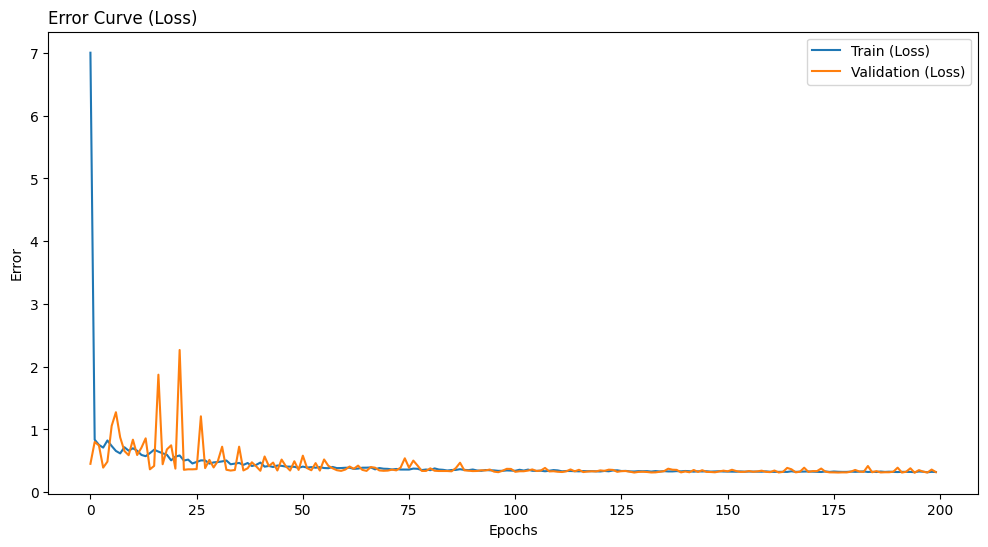

In [170]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=history_v1.history, y="loss", x=range(len(history_v1.history["loss"])), label='Train (Loss)')
sns.lineplot(data=history_v1.history, y="val_loss", x=range(len(history_v1.history["val_loss"])), label='Validation (Loss)')
plt.title('Error Curve (Loss)', loc="left")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show();

In [171]:
model_keras_v2 = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.drop(cols_to_drop, axis=1).shape[1],)),
    layers.Dense(12, activation='relu', input_shape=(X_train.drop(cols_to_drop, axis=1).shape[1],)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_keras_v2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history_v2 = model_keras_v2.fit(
    X_train.drop(cols_to_drop, axis=1), y_train,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

Epoch 1/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6194 - loss: 1.7936 - val_accuracy: 0.4909 - val_loss: 0.6505
Epoch 2/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - accuracy: 0.6660 - loss: 0.6174 - val_accuracy: 0.6677 - val_loss: 0.6133
Epoch 3/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - accuracy: 0.6867 - loss: 0.6029 - val_accuracy: 0.7119 - val_loss: 0.5784
Epoch 4/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7082 - loss: 0.5880 - val_accuracy: 0.6786 - val_loss: 0.6091
Epoch 5/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.7079 - loss: 0.5815 - val_accuracy: 0.7064 - val_loss: 0.5863
Epoch 6/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - accuracy: 0.7252 - loss: 0.5717 - val_accuracy: 0.7082 - val_loss: 0.5862
Epoch 7/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7390 - loss: 0.5513 - val_accuracy: 0.7488 - val_loss: 0.5315
Epoch 8/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - accuracy: 0.7415 - loss: 0.5461 

In [172]:
result_keras_v2_prob = model_keras_v2.predict(X_test.drop(cols_to_drop, axis=1))
result_keras_v2 = (result_keras_v2_prob > 0.5).astype("int32")

# model_path = save_model_on_blob(model_keras_v2, type(model_keras_v2).__name__)
quantify_model_prediction(y_test, result_keras_v2)
register_model_experiment("Deep Learning_v2", y_test, result_keras_v2, "Test", grid_cv)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


2025/10/31 21:44:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Deep Learning_v2' already exists. Creating a new version of this model...
2025/10/31 21:44:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Deep Learning_v2, version 5
Created version '5' of model 'Deep Learning_v2'.
Registered model 'Deep Learning_v2' already exists. Creating a new version of this model...
2025/10/31 21:44:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Deep Learning_v2, version 6


Registered Model: Deep Learning_v2
🏃 View run Deep Learning_v2_2025-10-31 21:44:37.622971 at: http://localhost:5000/#/experiments/488898870833171410/runs/5df67efeea10493abc998e8535b0294b
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


Created version '6' of model 'Deep Learning_v2'.


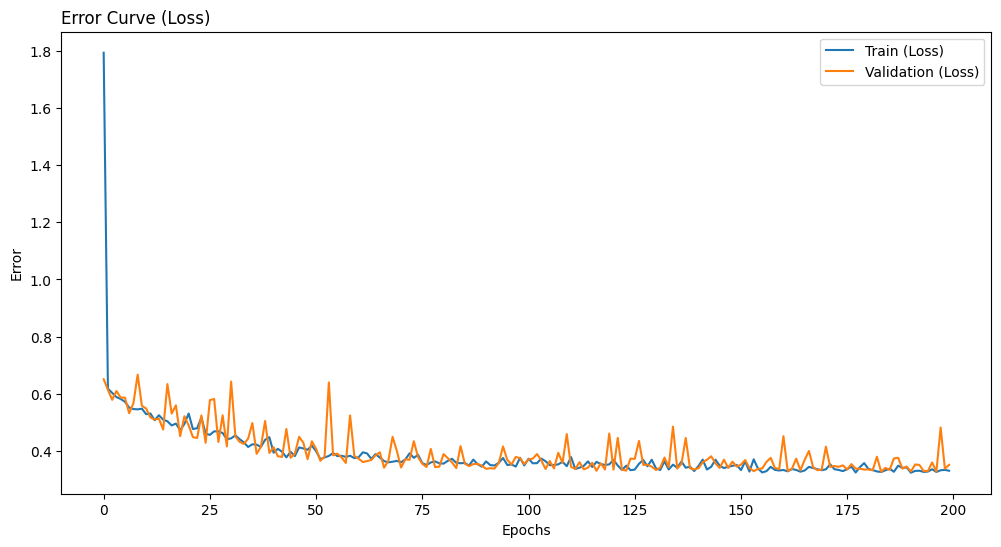

In [173]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=history_v2.history, y="loss", x=range(len(history_v2.history["loss"])), label='Train (Loss)')
sns.lineplot(data=history_v2.history, y="val_loss", x=range(len(history_v2.history["val_loss"])), label='Validation (Loss)')
plt.title('Error Curve (Loss)', loc="left")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show();

In [174]:
scaler = StandardScaler().fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [175]:
model_keras_v3 = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_scaler.shape[1],)),
    layers.Dense(12, activation='relu', input_shape=(X_train_scaler.shape[1],)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_keras_v3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history_v3 = model_keras_v3.fit(
    X_train_scaler, y_train,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

Epoch 1/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8083 - loss: 0.3958 - val_accuracy: 0.8378 - val_loss: 0.3300
Epoch 2/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8485 - loss: 0.3188 - val_accuracy: 0.8517 - val_loss: 0.3146
Epoch 3/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - accuracy: 0.8587 - loss: 0.3060 - val_accuracy: 0.8499 - val_loss: 0.3094
Epoch 4/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - accuracy: 0.8559 - loss: 0.2990 - val_accuracy: 0.8469 - val_loss: 0.3091
Epoch 5/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.8627 - loss: 0.2949 - val_accuracy: 0.8384 - val_loss: 0.3278
Epoch 6/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - accuracy: 0.8671 - loss: 0.2883 - val_accuracy: 0.8396 - val_loss: 0.3248
Epoch 7/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8656 - loss: 0.2866 - val_accuracy: 0.8426 - val_loss: 0.3160
Epoch 8/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - accuracy: 0.8680 - loss: 0.2822 

In [176]:
result_keras_v3_prob = model_keras_v3.predict(X_test_scaler)
result_keras_v3 = (result_keras_v3_prob > 0.5).astype("int32")

# model_path = save_model_on_blob(model_keras_v3, type(model_keras_v3).__name__)
quantify_model_prediction(y_test, result_keras_v3)
register_model_experiment("Deep Learning_v3", y_test, result_keras_v3, "Test", grid_cv)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


2025/10/31 21:47:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Deep Learning_v3' already exists. Creating a new version of this model...
2025/10/31 21:47:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Deep Learning_v3, version 5
Created version '5' of model 'Deep Learning_v3'.
Registered model 'Deep Learning_v3' already exists. Creating a new version of this model...
2025/10/31 21:47:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Deep Learning_v3, version 6


Registered Model: Deep Learning_v3
🏃 View run Deep Learning_v3_2025-10-31 21:47:33.777182 at: http://localhost:5000/#/experiments/488898870833171410/runs/976786d4a9d84d6ca45605b275654806
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


Created version '6' of model 'Deep Learning_v3'.


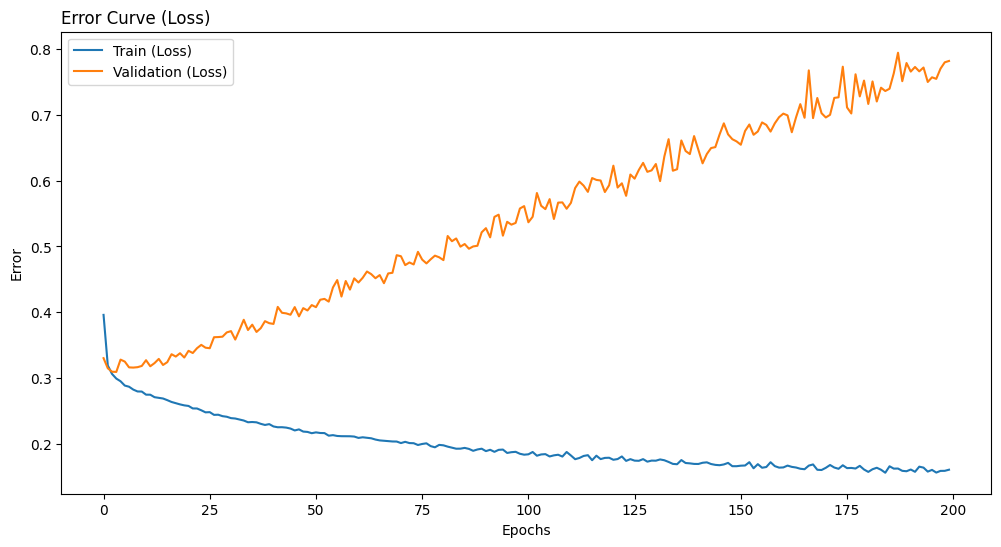

In [177]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=history_v3.history, y="loss", x=range(len(history_v3.history["loss"])), label='Train (Loss)')
sns.lineplot(data=history_v3.history, y="val_loss", x=range(len(history_v3.history["val_loss"])), label='Validation (Loss)')
plt.title('Error Curve (Loss)', loc="left")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show();

In [178]:
model_keras_v4 = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_scaler.shape[1],)),
    layers.Dense(12, activation='relu', input_shape=(X_train_scaler.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_keras_v4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history_v4 = model_keras_v4.fit(
    X_train_scaler, y_train,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

Epoch 1/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7104 - loss: 0.5647 - val_accuracy: 0.8142 - val_loss: 0.4170
Epoch 2/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8067 - loss: 0.4300 - val_accuracy: 0.8438 - val_loss: 0.3470
Epoch 3/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8258 - loss: 0.3949 - val_accuracy: 0.8499 - val_loss: 0.3347
Epoch 4/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8328 - loss: 0.3793 - val_accuracy: 0.8505 - val_loss: 0.3304
Epoch 5/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8317 - loss: 0.3755 - val_accuracy: 0.8481 - val_loss: 0.3223
Epoch 6/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8346 - loss: 0.3745 - val_accuracy: 0.8505 - val_loss: 0.3179
Epoch 7/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8397 - loss: 0.3606 - val_accuracy: 0.8475 - val_loss: 0.3211
Epoch 8/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8381 - loss: 0.3623 - val_accu

In [179]:
result_keras_v4_prob = model_keras_v4.predict(X_test_scaler)
result_keras_v4 = (result_keras_v4_prob > 0.5).astype("int32")

# model_path = save_model_on_blob(model_keras_v4, type(model_keras_v4).__name__)
quantify_model_prediction(y_test, result_keras_v4)
register_model_experiment("Deep Learning_v4", y_test, result_keras_v4, "Test", grid_cv)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2025/10/31 21:50:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Deep Learning_v4' already exists. Creating a new version of this model...
2025/10/31 21:50:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Deep Learning_v4, version 5
Created version '5' of model 'Deep Learning_v4'.
Registered model 'Deep Learning_v4' already exists. Creating a new version of this model...
2025/10/31 21:50:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Deep Learning_v4, version 6


Registered Model: Deep Learning_v4
🏃 View run Deep Learning_v4_2025-10-31 21:50:45.215992 at: http://localhost:5000/#/experiments/488898870833171410/runs/1a7242bf7d164fdb8f646bd12fb2080a
🧪 View experiment at: http://localhost:5000/#/experiments/488898870833171410


Created version '6' of model 'Deep Learning_v4'.


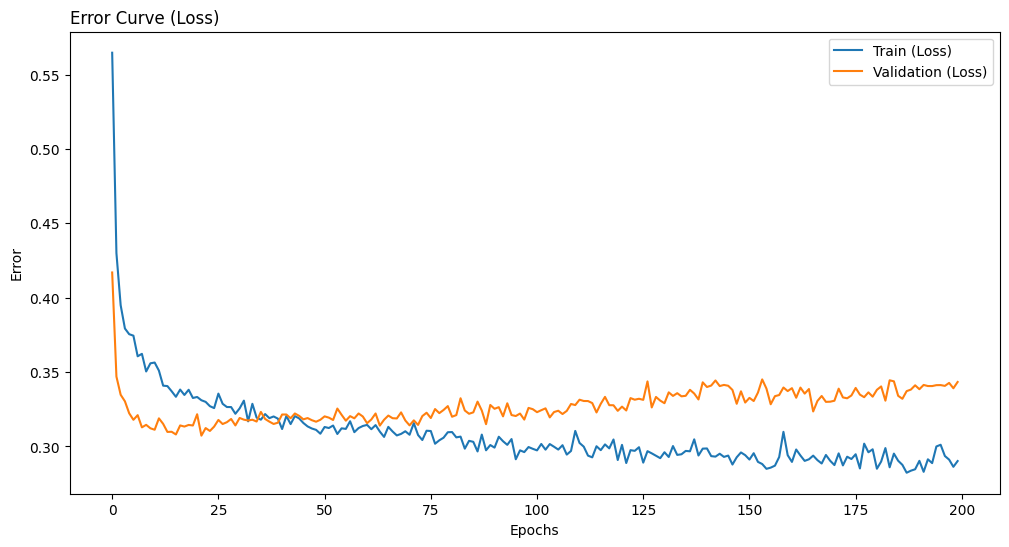

In [180]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=history_v4.history, y="loss", x=range(len(history_v4.history["loss"])), label='Train (Loss)')
sns.lineplot(data=history_v4.history, y="val_loss", x=range(len(history_v4.history["val_loss"])), label='Validation (Loss)')
plt.title('Error Curve (Loss)', loc="left")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show();

In [181]:
end_time = datetime.now()
delta = end_time - start_time
print(delta)

0:29:38.215391
